#HHT Features

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/content/gdrive/MyDrive/MSc_Thesis')

In [4]:
!pip install ta
!pip install EMD-signal
!pip install pyhht
!pip install hurst
!pip install pytrends
import itertools
import utils 
import helper_funcs
import pytrends 
from pytrends.request import TrendReq
import gtrend 
from importlib import reload  
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, mean_squared_error
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import ta
import PyEMD 
import pyhht 
import matplotlib.pyplot as plt
import scipy 
from scipy import fftpack, stats
import matplotlib.ticker as mtick
import datetime 
from datetime import date
import hurst 
from hurst import compute_Hc
import random 
import time 
from datetime import datetime, timedelta, date, time
from PyEMD import CEEMDAN, Visualisation


  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=dfb410efda146adbdbf18a505780baaaa115b67a95ff1ec2dace99abacea9921
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta
     |████████████████████████████████| 42 kB 779 kB/s 
     |████████████████████████████████| 47 kB 5.7 MB/s 
     |████████████████████████████████| 81 kB 11.6 MB/s 
     |████████████████████████████████| 65 kB 4.2 MB/s 


In [126]:
XOM_data = pd.read_excel('/content/gdrive/MyDrive/MSc_Thesis/Exon_Mobil_Data/XOM_full_data.xlsx')
#XOM_returns = XOM_returns
dates = XOM_data['Dates']
XOM_data['Daily Return'] = XOM_data['XOM Closing price'] / XOM_data['XOM Closing price'].shift(1) - 1 
XOM_returns = XOM_data['Daily Return']
XOM_returns = pd.DataFrame(data = XOM_returns.values, index = dates, columns = ['Daily Returns'])
#XOM_returns.dropna(inplace=True)
print(XOM_returns.shape)
print(type(XOM_returns))

XOM_returns.tail()

(5762, 1)
<class 'pandas.core.frame.DataFrame'>


,Daily Returns
Dates,
2021-04-29,0.014283
2021-04-30,-0.028843
2021-05-03,0.027603
2021-05-04,0.006290
2021-05-05,0.017768


In [127]:
returns_XOM = pd.DataFrame(data = XOM_returns.values, index = dates, columns = ['Daily Returns'])
pd.to_datetime(returns_XOM.index)
returns_XOM.dropna(inplace=True)
returns_XOM = returns_XOM + 1


# Manually checking if the weekly returns have been computed appropriately

In [128]:
returns_XOM
log_XOM_returns = np.log(returns_XOM)

In [129]:
XOM_returns_var = np.array(returns_XOM).reshape(-1)
XOM_log_returns = np.log(np.array(returns_XOM).reshape(-1))

In [130]:
XOM_log_returns

array([0.0068552 , 0.01441177, 0.0058763 , ..., 0.02722898, 0.00627068,
       0.01761219])

In [131]:
XOM_returns_var

array([1.00687875, 1.01451612, 1.0058936 , ..., 1.02760307, 1.00629038,
       1.0177682 ])

In [132]:
t = np.arange(0, len(XOM_log_returns), 1)
ceemdan = CEEMDAN()


In [133]:
# Ensure the array passed to ceemdan() and t defined above have the same ndims - check using np.ndims

cIMFs = ceemdan(XOM_log_returns)
imfs, res = ceemdan.get_imfs_and_residue()


In [134]:
print(f"IMFs shape: {imfs.shape}")
print(f"Residue shape: {res.shape}")


IMFs shape: (11, 5761)
Residue shape: (5761,)


In [135]:
def compute_hilbert_transform(imfs):

    # Computing the Hilbert transform on the IMFs
    # returns an array of the hilbert transforms

    hilbert = []

    for i in range(len(imfs)):
        
        k = fftpack.hilbert(imfs[i])
        hilbert.append(k)

    hilbert = np.array(hilbert)

    return hilbert

def plotter(imfs, hilbert):
    t = np.arange(0, len(imfs.T), 1)
    t1 = np.arange(0, len(hilbert.T), 1)
    fig, axs = plt.subplots(len(hilbert), sharex=True, figsize=(8, 24))
    for i in range(len(hilbert)):
        axs[i].plot(t, hilbert[i], label='Hilbert Transform', color='lightcoral')
        axs[i].set_title(f'cIMF {i}')
        axs[i].plot(t1, imfs[i], label='IMF Component', color='cornflowerblue')
        axs[i].set_title(f'IMF {i}')
        axs[i].legend()



In [136]:
XOM_hilberts = compute_hilbert_transform(imfs)
XOM_amplitudes = helper_funcs.compute_amplitude(imfs, XOM_hilberts)
XOM_IF = helper_funcs.compute_instantaneous_frequency(imfs, XOM_hilberts)

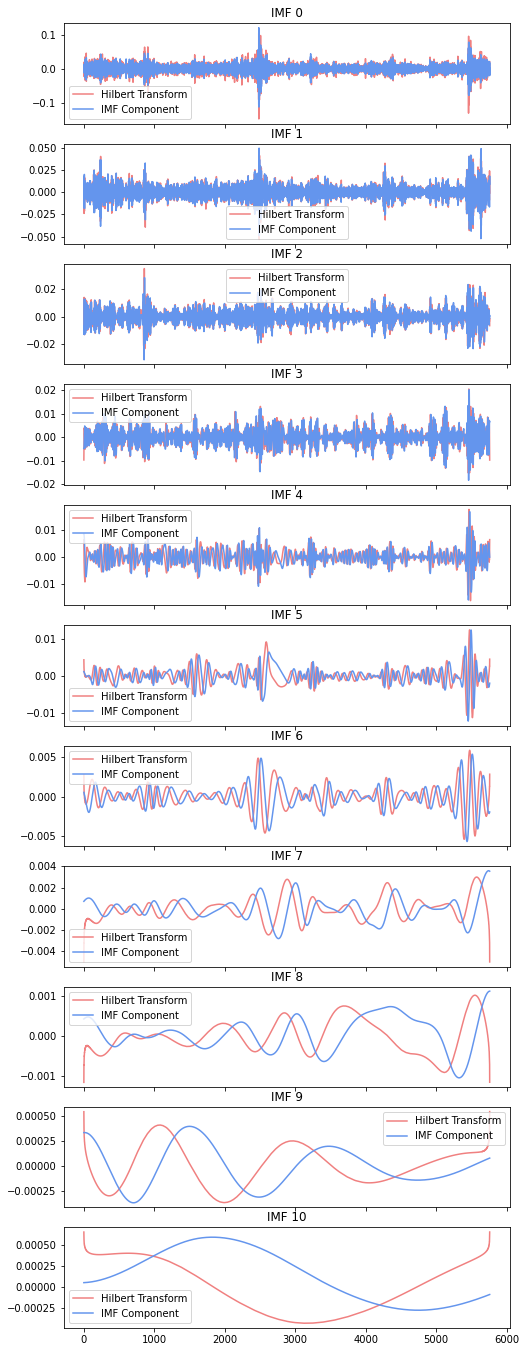

In [137]:
plotter(imfs, XOM_hilberts)

In [138]:
XOM_HHT_df = helper_funcs.create_HHT_dataframe(imfs, XOM_hilberts, 
                                               XOM_amplitudes, XOM_IF,
                                                XOM_log_returns, 'daily',
                                                returns_XOM)
                                                

In [139]:
print(len(XOM_HHT_df))
XOM_HHT_df.head()

5761


,IMF_1,IMF_2,IMF_3,IMF_4,IMF_5,IMF_6,IMF_7,IMF_8,IMF_9,IMF_10,IMF_11,Complex IMF_1,Complex IMF_2,Complex IMF_3,Complex IMF_4,Complex IMF_5,Complex IMF_6,Complex IMF_7,Complex IMF_8,Complex IMF_9,Complex IMF_10,Complex IMF_11,Amp_1,Amp_2,Amp_3,Amp_4,Amp_5,Amp_6,Amp_7,Amp_8,Amp_9,Amp_10,Amp_11,IF_1,IF_2,IF_3,IF_4,IF_5,IF_6,IF_7,IF_8,IF_9,IF_10,IF_11
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-07,-0.001858,0.004821,-0.005779,0.008232,0.005245,-0.012972,0.013282,-0.012277,0.011298,-0.009788,-0.012625,-0.007290,0.011387,-0.009054,0.019177,-0.023184,0.015002,-0.007985,0.002853,-0.000119,-0.011850,0.011545,0.007523,0.012366,0.010741,0.020869,0.023770,0.019833,0.015498,0.012604,0.011299,0.015370,0.017107,1.321162,1.170278,1.002675,1.165319,-1.348308,-0.857842,-0.541257,-0.228318,-0.010568,0.880434,-0.740740
1999-04-08,0.014984,-0.011396,-0.020985,-0.009133,0.025456,0.023838,-0.026931,0.026735,-0.002152,-0.020782,-0.023168,0.005832,-0.020715,0.015502,0.019246,0.034248,-0.033587,0.009899,0.007490,-0.021199,-0.008433,0.029223,0.016079,0.023643,0.026090,0.021303,0.042672,0.041187,0.028693,0.027764,0.021307,0.022428,0.037293,0.371169,1.067868,-0.636256,-1.127701,0.931611,-0.953563,-0.352260,0.273162,1.469639,0.385460,-0.900458
1999-04-09,0.020893,0.020013,0.017694,-0.011985,0.009276,-0.007782,0.008643,-0.012294,0.009751,0.010199,0.029778,0.025543,0.005710,-0.016640,-0.002910,0.000628,0.000071,0.001339,0.002067,0.015752,0.008426,-0.014325,0.032999,0.020812,0.024289,0.012333,0.009297,0.007783,0.008746,0.012466,0.018526,0.013229,0.033044,0.885213,0.277915,-0.754705,0.238203,0.067632,-0.009144,0.153687,-0.166607,1.016523,0.690484,-0.448372
1999-04-12,-0.033087,0.017025,0.031869,-0.028357,0.024037,0.005851,-0.015626,0.012241,-0.009689,0.008114,0.004907,-0.018445,0.045507,-0.036896,-0.000272,0.013410,-0.027351,0.002466,0.000741,-0.008888,0.011606,-0.017364,0.037881,0.048588,0.048754,0.028358,0.027525,0.027970,0.015819,0.012263,0.013148,0.014161,0.018044,0.508563,1.212799,-0.858376,0.009606,0.508894,-1.360063,-0.156520,0.060428,0.742303,0.960679,-1.295382
1999-04-13,-0.008138,0.009620,-0.004648,-0.014128,0.016269,0.003836,-0.018721,0.018761,0.002916,-0.016760,-0.014237,0.004357,-0.003720,-0.011650,0.005058,0.013628,-0.026142,0.010989,0.003770,-0.017396,-0.014013,0.019178,0.009231,0.010314,0.012543,0.015007,0.021223,0.026422,0.021708,0.019136,0.017639,0.021846,0.023885,-0.491546,-0.368958,1.191159,-0.343808,0.697298,-1.425094,-0.530784,0.198309,-1.404730,0.696370,-0.932192


In [140]:
# This is correlation with log price 

helper_funcs.find_lagged_correlations(XOM_HHT_df, XOM_log_returns)

Correlation between IMF_1 and the Returns: -0.019000705847737942
Correlation between IMF_2 and the Returns: -0.003432723660224807
Correlation between IMF_3 and the Returns: 0.008429234147012478
Correlation between IMF_4 and the Returns: 0.0037653180711862528
Correlation between IMF_5 and the Returns: -0.0059495051190046975
Correlation between IMF_6 and the Returns: -0.013135023131307202
Correlation between IMF_7 and the Returns: 0.011366283775887684
Correlation between IMF_8 and the Returns: 0.014429566813026866
Correlation between IMF_9 and the Returns: -0.016140437153738
Correlation between IMF_10 and the Returns: -0.01816913127886761
Correlation between IMF_11 and the Returns: -0.017608543232420185
Correlation between Complex IMF_1 and the Returns: -0.027826854613439814
Correlation between Complex IMF_2 and the Returns: 0.016539170383993794
Correlation between Complex IMF_3 and the Returns: -0.010699257965075667
Correlation between Complex IMF_4 and the Returns: -0.00529886418031117

In [141]:
# This is correlation with normal returns 

helper_funcs.find_lagged_correlations(XOM_HHT_df, XOM_returns_var)

Correlation between IMF_1 and the Returns: -0.019107023693393285
Correlation between IMF_2 and the Returns: -0.003733033462127585
Correlation between IMF_3 and the Returns: 0.008035752072222046
Correlation between IMF_4 and the Returns: 0.003620877430654591
Correlation between IMF_5 and the Returns: -0.006159712317286521
Correlation between IMF_6 and the Returns: -0.01329910647700131
Correlation between IMF_7 and the Returns: 0.011183792877736829
Correlation between IMF_8 and the Returns: 0.014568857128981073
Correlation between IMF_9 and the Returns: -0.016303714155149727
Correlation between IMF_10 and the Returns: -0.018213754308604887
Correlation between IMF_11 and the Returns: -0.01794100021453362
Correlation between Complex IMF_1 and the Returns: -0.028124160768911863
Correlation between Complex IMF_2 and the Returns: 0.016254192862680896
Correlation between Complex IMF_3 and the Returns: -0.010688972267790602
Correlation between Complex IMF_4 and the Returns: -0.00523946213787171

In [142]:
# log returns
scaled_HHT_df = helper_funcs.scale_dataset(XOM_HHT_df, min=False)
scaled_HHT_df = scaled_HHT_df.join(pd.DataFrame(log_XOM_returns), how ='left')
scaled_HHT_df.head()

,IMF_1,IMF_2,IMF_3,IMF_4,IMF_5,IMF_6,IMF_7,IMF_8,IMF_9,IMF_10,IMF_11,Complex IMF_1,Complex IMF_2,Complex IMF_3,Complex IMF_4,Complex IMF_5,Complex IMF_6,Complex IMF_7,Complex IMF_8,Complex IMF_9,Complex IMF_10,Complex IMF_11,Amp_1,Amp_2,Amp_3,Amp_4,Amp_5,Amp_6,Amp_7,Amp_8,Amp_9,Amp_10,Amp_11,IF_1,IF_2,IF_3,IF_4,IF_5,IF_6,IF_7,IF_8,IF_9,IF_10,IF_11,Daily Returns
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-07,-0.305517,0.759905,-0.919824,1.324036,0.830580,-1.926338,2.041871,-1.823411,1.630031,-1.473924,-1.916645,-1.099998,1.826247,-1.499540,2.972495,-3.365426,2.304662,-1.182138,0.421682,-0.037513,-1.806511,1.732152,0.213307,0.964051,0.751397,2.209685,2.507978,1.926292,1.311586,0.906433,0.720404,1.317956,1.564809,1.485814,1.307619,1.110753,1.286600,-1.531802,-0.971857,-0.599709,-0.235451,-0.010514,0.997964,-0.813206,0.006855
1999-04-08,2.304683,-1.783250,-3.321203,-1.434465,4.068545,3.559644,-4.096160,4.022909,-0.317932,-3.129549,-3.522496,0.886905,-3.315028,2.594692,2.983131,4.959166,-5.104836,1.464843,1.119096,-3.307922,-1.282452,4.412616,1.437070,2.664162,3.157441,2.274177,5.184261,4.921702,3.157859,3.013584,2.109171,2.318368,4.428649,0.422283,1.193369,-0.723257,-1.289709,1.036707,-1.079372,-0.387083,0.324566,1.636800,0.441819,-0.990680,0.014412
1999-04-09,3.220344,3.142357,2.787291,-1.887394,1.476388,-1.152854,1.333748,-1.825991,1.405910,1.535704,4.541551,3.871610,0.917024,-2.764316,-0.448176,0.086094,0.027773,0.197810,0.303582,2.424964,1.302638,-2.190221,3.857040,2.237420,2.875148,0.940372,0.458886,0.235896,0.366918,0.887357,1.723216,1.014584,3.825829,0.997763,0.312094,-0.855805,0.244944,0.063366,-0.018592,0.182117,-0.166537,1.132529,0.784540,-0.488331,0.005876
1999-04-12,-5.145120,2.673730,5.025899,-4.488135,3.841219,0.878905,-2.370572,1.850799,-1.409565,1.221756,0.753578,-2.789184,7.290766,-6.141589,-0.039684,1.938815,-4.153891,0.364613,0.104047,-1.397941,1.790359,-2.651125,4.555209,6.424866,6.710225,3.323267,3.039604,3.067682,1.356547,0.859096,0.977007,1.146715,1.697740,0.576097,1.355055,-0.971815,-0.011894,0.560484,-1.535957,-0.166873,0.087000,0.827351,1.088126,-1.429513,0.009992
1999-04-13,-1.278668,1.512427,-0.741176,-2.227932,2.596719,0.578679,-2.843036,2.827916,0.416010,-2.523809,-2.162242,0.663533,-0.593144,-1.932322,0.785907,1.970382,-3.969542,1.626043,0.559628,-2.718036,-2.138134,2.889532,0.457596,0.654752,1.033796,1.337948,2.147344,2.850576,2.180512,1.814337,1.600171,2.235881,2.526387,-0.543541,-0.409561,1.321671,-0.408971,0.772735,-1.609000,-0.587927,0.240975,-1.562069,0.791152,-1.025943,-0.003320


In [143]:
X_XOM_1_HHT, Y_XOM_1_HHT = helper_funcs.create_datasets(1, 1, XOM_log_returns, 'XOM', scaled_HHT_df, False)
X_XOM_2_HHT, Y_XOM_2_HHT = helper_funcs.create_datasets(2, 1, XOM_log_returns, 'XOM', scaled_HHT_df, False)
X_XOM_3_HHT, Y_XOM_3_HHT = helper_funcs.create_datasets(3, 1, XOM_log_returns, 'XOM', scaled_HHT_df, False)
X_XOM_5_HHT, Y_XOM_5_HHT = helper_funcs.create_datasets(5, 1, XOM_log_returns, 'XOM', scaled_HHT_df, False)
X_XOM_10_HHT, Y_XOM_10_HHT = helper_funcs.create_datasets(10, 1, XOM_log_returns, 'XOM', scaled_HHT_df, False)

Shape of X: (5760, 1, 45) Shape of Y: (5760, 1)
Shape of X: (5759, 2, 45) Shape of Y: (5759, 1)
Shape of X: (5758, 3, 45) Shape of Y: (5758, 1)
Shape of X: (5756, 5, 45) Shape of Y: (5756, 1)
Shape of X: (5751, 10, 45) Shape of Y: (5751, 1)


In [144]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [145]:
x_train_1_HHT, y_train_1_HHT, x_val_1_HHT, y_val_1_HHT, x_test_1_HHT, y_test_1_HHT = helper_funcs.data_split(X_XOM_1_HHT, Y_XOM_1_HHT)
x_train_1_HHT, y_train_1_HHT, x_val_1_HHT, y_val_1_HHT, x_test_1_HHT, y_test_1_HHT = x_train_1_HHT.to(device), y_train_1_HHT.to(device), x_val_1_HHT.to(device), y_val_1_HHT.to(device), x_test_1_HHT.to(device), y_test_1_HHT.to(device)

In [146]:
x_train_2_HHT, y_train_2_HHT, x_val_2_HHT, y_val_2_HHT, x_test_2_HHT, y_test_2_HHT = helper_funcs.data_split(X_XOM_2_HHT, Y_XOM_2_HHT)
x_train_2_HHT, y_train_2_HHT, x_val_2_HHT, y_val_2_HHT, x_test_2_HHT, y_test_2_HHT = x_train_2_HHT.to(device), y_train_2_HHT.to(device), x_val_2_HHT.to(device), y_val_2_HHT.to(device), x_test_2_HHT.to(device), y_test_2_HHT.to(device)

In [147]:
x_train_3_HHT, y_train_3_HHT, x_val_3_HHT, y_val_3_HHT, x_test_3_HHT, y_test_3_HHT = helper_funcs.data_split(X_XOM_3_HHT, Y_XOM_3_HHT)
x_train_3_HHT, y_train_3_HHT, x_val_3_HHT, y_val_3_HHT, x_test_3_HHT, y_test_3_HHT = x_train_3_HHT.to(device), y_train_3_HHT.to(device), x_val_3_HHT.to(device), y_val_3_HHT.to(device), x_test_3_HHT.to(device), y_test_3_HHT.to(device)

In [148]:
x_train_5_HHT, y_train_5_HHT, x_val_5_HHT, y_val_5_HHT, x_test_5_HHT, y_test_5_HHT = helper_funcs.data_split(X_XOM_5_HHT, Y_XOM_5_HHT)
x_train_5_HHT, y_train_5_HHT, x_val_5_HHT, y_val_5_HHT, x_test_5_HHT, y_test_5_HHT = x_train_5_HHT.to(device), y_train_5_HHT.to(device), x_val_5_HHT.to(device), y_val_5_HHT.to(device), x_test_5_HHT.to(device), y_test_5_HHT.to(device)

In [149]:
x_train_10_HHT, y_train_10_HHT, x_val_10_HHT, y_val_10_HHT, x_test_10_HHT, y_test_10_HHT = helper_funcs.data_split(X_XOM_10_HHT, Y_XOM_10_HHT)
x_train_10_HHT, y_train_10_HHT, x_val_10_HHT, y_val_10_HHT, x_test_10_HHT, y_test_10_HHT = x_train_10_HHT.to(device), y_train_10_HHT.to(device), x_val_10_HHT.to(device), y_val_10_HHT.to(device), x_test_10_HHT.to(device), y_test_10_HHT.to(device)

In [150]:
class LSTM(nn.Module):
  def __init__(self, n_inputs, n_hidden, num_layers, n_outputs):
    super(LSTM, self).__init__()

    self.input_size = n_inputs
    self.hidden_size = n_hidden
    self.num_layers = num_layers
    self.n_outputs = n_outputs

    self.rnn = nn.LSTM(
        self.input_size,
        self.hidden_size,
        self.num_layers,
        batch_first=True)
    
    self.fc = nn.Linear(self.hidden_size, self.n_outputs)
    
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device) # For BiDir LSTM need to multiply self.L x 2
    c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device) # For BiDir LSTM need to multiply self.L x 2
        
    # get RNN unit output
    out, _ = self.rnn(X, (h0, c0))
    #(seq_len, batch, num_directions * hidden_size)

    Hidden = _[0]
    Cell = _[1]
    #(num_layers * num_directions, batch, hidden_size)

    out = self.fc(out[:, -1, :])

    return out

In [200]:
# Training

def full_gd(model,
            loss_function,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            no_epochs):

  # Stuff to store
  train_losses = np.zeros(no_epochs)
  test_losses = np.zeros(no_epochs)

  for it in range(no_epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = loss_function(outputs, y_train)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = loss_function(test_outputs, y_test)
        test_losses[it] = test_loss.item()
      
    if (it + 1) % 250} == 0:
      print(f'Epoch {it+1}/{no_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {test_loss.item():.4f}')
  
  return train_losses, test_losses

SyntaxError: ignored

In [152]:
Hidden = 512

XOM_1_model_HHT = LSTM(len(X_XOM_1_HHT.T), Hidden, 1, 1) 
XOM_2_model_HHT = LSTM(len(X_XOM_2_HHT.T), Hidden, 1, 1) 
XOM_3_model_HHT = LSTM(len(X_XOM_3_HHT.T), Hidden, 1, 1) 
XOM_5_model_HHT = LSTM(len(X_XOM_5_HHT.T), Hidden, 1, 1) 
XOM_10_model_HHT = LSTM(len(X_XOM_10_HHT.T), Hidden, 1, 1) 


XOM_1_model_HHT.to(device)
XOM_2_model_HHT.to(device)
XOM_3_model_HHT.to(device)
XOM_5_model_HHT.to(device)
XOM_10_model_HHT.to(device)


learning_rate = 1e-4

XOM_1_model_optimizer_HHT = torch.optim.Adam(XOM_1_model_HHT.parameters(), lr = learning_rate)
XOM_2_model_optimizer_HHT = torch.optim.Adam(XOM_2_model_HHT.parameters(), lr = learning_rate)
XOM_3_model_optimizer_HHT = torch.optim.Adam(XOM_3_model_HHT.parameters(), lr = learning_rate)
XOM_5_model_optimizer_HHT = torch.optim.Adam(XOM_5_model_HHT.parameters(), lr = learning_rate)
XOM_10_model_optimizer_HHT = torch.optim.Adam(XOM_10_model_HHT.parameters(), lr = learning_rate)


loss_function = nn.MSELoss()

epochs = 500
train_loss_1_HHT, validation_loss_1_HHT = full_gd(XOM_1_model_HHT,
                                      loss_function,
                                      XOM_1_model_optimizer_HHT,
                                      x_train_1_HHT, 
                                      y_train_1_HHT, 
                                      x_val_1_HHT,
                                      y_val_1_HHT, 
                                      epochs)
print('\n')
train_loss_2_HHT, validation_loss_2_HHT = full_gd(XOM_2_model_HHT,
                                      loss_function,
                                      XOM_2_model_optimizer_HHT,
                                      x_train_2_HHT, 
                                      y_train_2_HHT, 
                                      x_val_2_HHT,
                                      y_val_2_HHT, 
                                      epochs)
print('\n')
train_loss_3_HHT, validation_loss_3_HHT = full_gd(XOM_3_model_HHT,
                                      loss_function,
                                      XOM_3_model_optimizer_HHT,
                                      x_train_3_HHT, 
                                      y_train_3_HHT, 
                                      x_val_3_HHT,
                                      y_val_3_HHT, 
                                      epochs)
print('\n')
train_loss_5_HHT, validation_loss_5_HHT = full_gd(XOM_5_model_HHT,
                                      loss_function,
                                      XOM_5_model_optimizer_HHT,
                                      x_train_5_HHT, 
                                      y_train_5_HHT, 
                                      x_val_5_HHT,
                                      y_val_5_HHT, 
                                      epochs)
print('\n')
train_loss_10_HHT, validation_loss_10_HHT = full_gd(XOM_10_model_HHT,
                                      loss_function,
                                      XOM_10_model_optimizer_HHT,
                                      x_train_10_HHT, 
                                      y_train_10_HHT, 
                                      x_val_10_HHT,
                                      y_val_10_HHT, 
                                      epochs)


Epoch 25/500, Train Loss: 0.0003, Validation Loss: 0.0001
Epoch 50/500, Train Loss: 0.0003, Validation Loss: 0.0001
Epoch 75/500, Train Loss: 0.0003, Validation Loss: 0.0001
Epoch 100/500, Train Loss: 0.0003, Validation Loss: 0.0001
Epoch 125/500, Train Loss: 0.0003, Validation Loss: 0.0001
Epoch 150/500, Train Loss: 0.0003, Validation Loss: 0.0001
Epoch 175/500, Train Loss: 0.0003, Validation Loss: 0.0001
Epoch 200/500, Train Loss: 0.0003, Validation Loss: 0.0001
Epoch 225/500, Train Loss: 0.0002, Validation Loss: 0.0001
Epoch 250/500, Train Loss: 0.0002, Validation Loss: 0.0001
Epoch 275/500, Train Loss: 0.0002, Validation Loss: 0.0001
Epoch 300/500, Train Loss: 0.0002, Validation Loss: 0.0001
Epoch 325/500, Train Loss: 0.0002, Validation Loss: 0.0001
Epoch 350/500, Train Loss: 0.0002, Validation Loss: 0.0001
Epoch 375/500, Train Loss: 0.0002, Validation Loss: 0.0001
Epoch 400/500, Train Loss: 0.0002, Validation Loss: 0.0001
Epoch 425/500, Train Loss: 0.0002, Validation Loss: 0.0001


In [153]:
def plot_loss_funcs(train_loss, validation_loss, day):
    plt.figure(figsize=(12,8))
    plt.plot(train_loss, label='Train loss')
    plt.plot(validation_loss, label='Validation loss')
    plt.title(f'Loss plots using {day} lookback')
    plt.legend()
    plt.show()

def plot_predicted_returns(predictions, actual_y):

    plt.figure(figsize = (15,8))
    plt.plot(actual_y.cpu(), color = 'red', label = 'True returns')
    plt.plot(predictions, color = 'green', label = 'Predictions')
    plt.legend()
    plt.show()

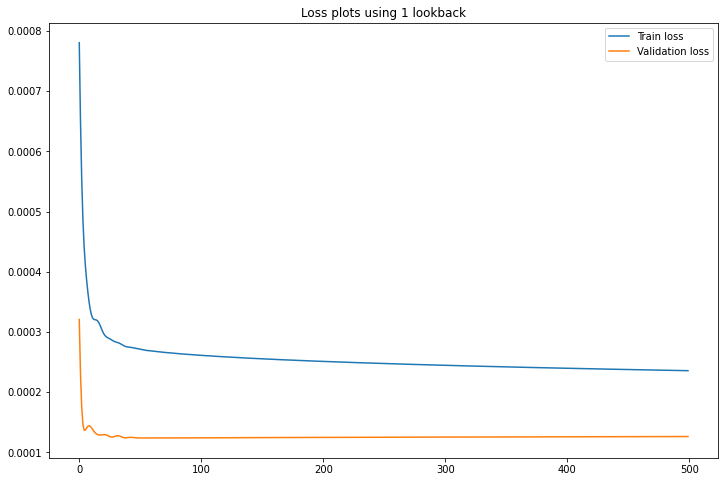

In [154]:
plot_loss_funcs(train_loss_1_HHT, validation_loss_1_HHT, 1)

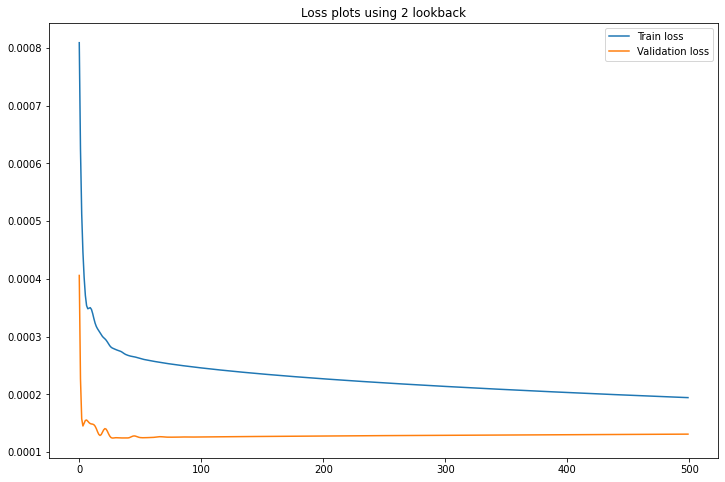

In [155]:
plot_loss_funcs(train_loss_2_HHT, validation_loss_2_HHT, 2)

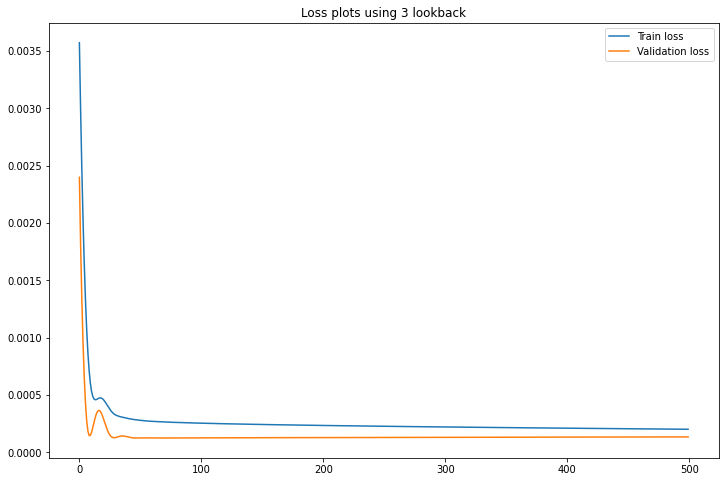

In [156]:
plot_loss_funcs(train_loss_3_HHT, validation_loss_3_HHT,3 )

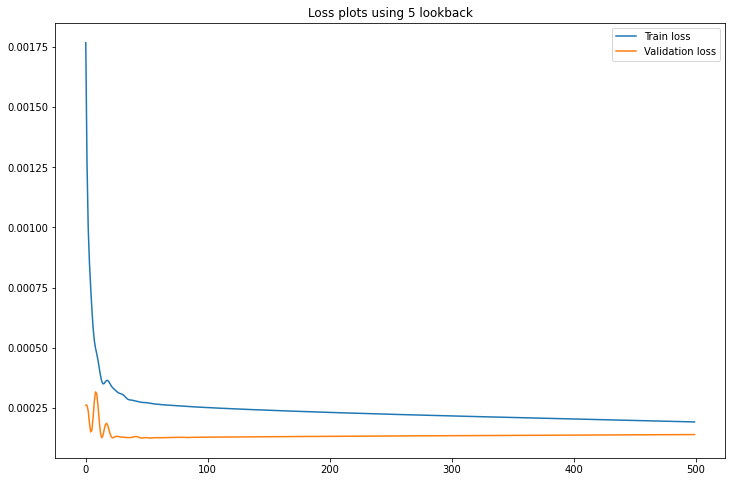

In [157]:
plot_loss_funcs(train_loss_5_HHT, validation_loss_5_HHT, 5)

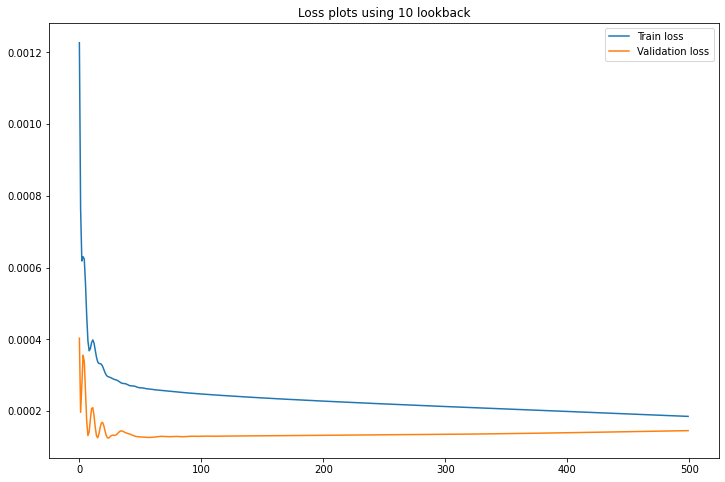

In [158]:
plot_loss_funcs(train_loss_10_HHT, validation_loss_10_HHT, 10)

In [159]:
predictions_1_HHT = helper_funcs.make_predictions(XOM_1_model_HHT, x_test_1_HHT, 
                                                  y_test_1_HHT, x_test_1_HHT.shape[1], 
                                                  len(x_test_1_HHT.T), False)

In [160]:
predictions_2_HHT = helper_funcs.make_predictions(XOM_2_model_HHT, x_test_2_HHT, 
                                                  y_test_2_HHT, x_test_2_HHT.shape[1], 
                                                  len(x_test_2_HHT.T), False)

In [161]:
predictions_3_HHT = helper_funcs.make_predictions(XOM_3_model_HHT, x_test_3_HHT, 
                                                  y_test_3_HHT, x_test_3_HHT.shape[1], 
                                                  len(x_test_3_HHT.T), False)

In [162]:
predictions_5_HHT = helper_funcs.make_predictions(XOM_5_model_HHT, x_test_5_HHT, 
                                                  y_test_5_HHT, x_test_5_HHT.shape[1], 
                                                  len(x_test_5_HHT.T), False)

In [163]:
predictions_10_HHT = helper_funcs.make_predictions(XOM_10_model_HHT, x_test_10_HHT, 
                                                  y_test_10_HHT, x_test_10_HHT.shape[1], 
                                                  len(x_test_10_HHT.T), False)

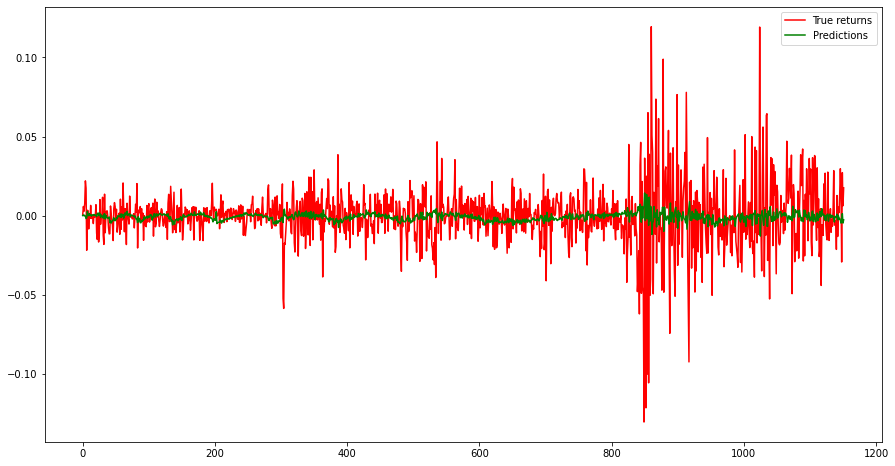

In [164]:
plot_predicted_returns(predictions_1_HHT, y_test_1_HHT)

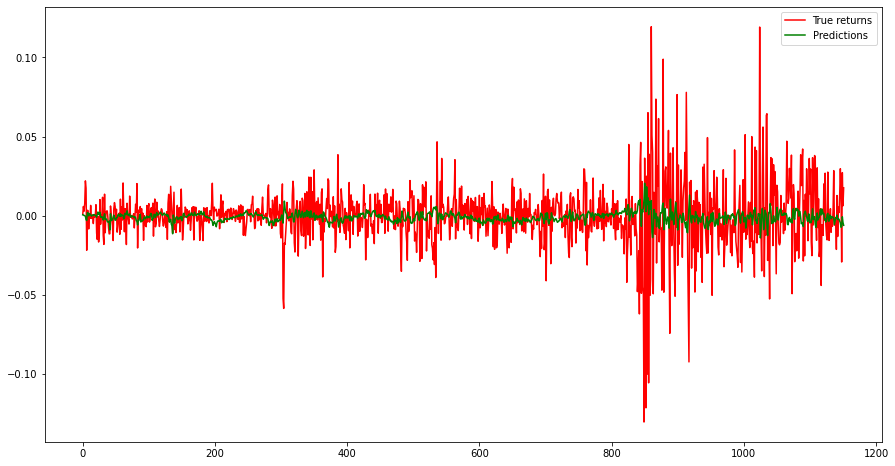

In [165]:
plot_predicted_returns(predictions_2_HHT, y_test_2_HHT)

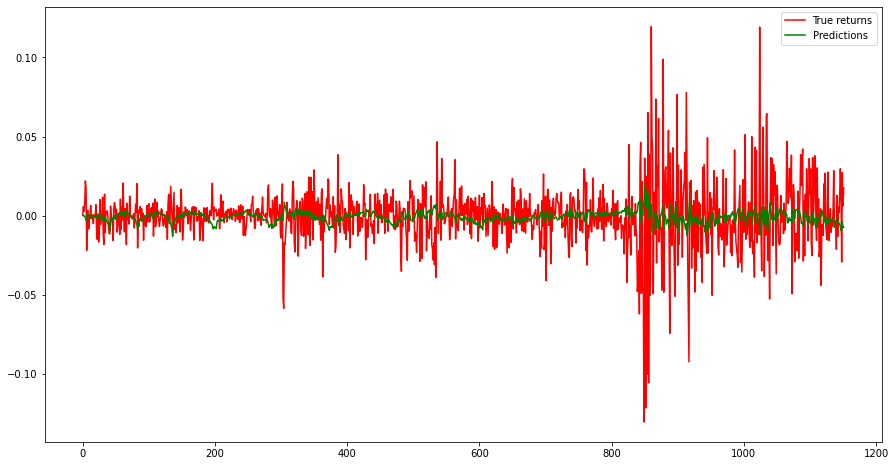

In [166]:
plot_predicted_returns(predictions_3_HHT, y_test_3_HHT)

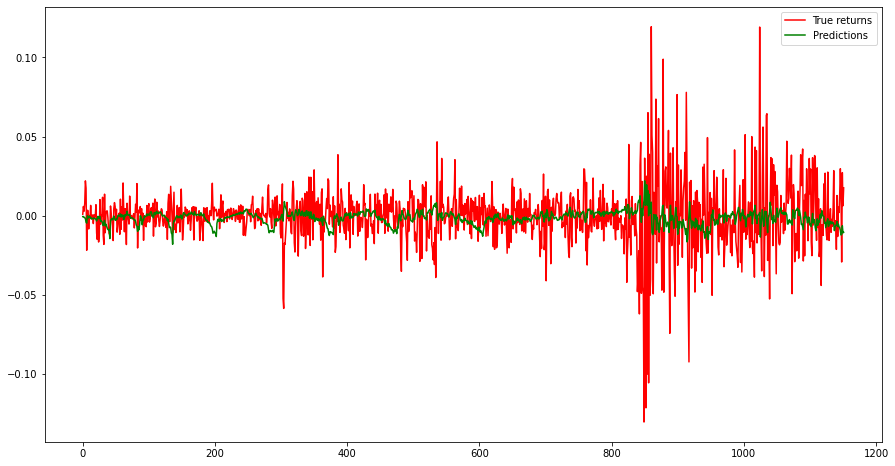

In [167]:
plot_predicted_returns(predictions_5_HHT, y_test_5_HHT)

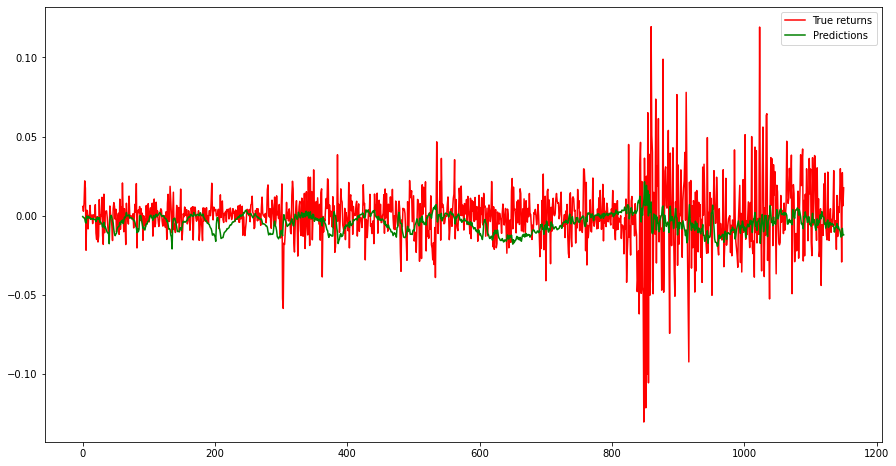

In [168]:
plot_predicted_returns(predictions_10_HHT, y_test_10_HHT)

In [ ]:
break

# Installing TimeSynth for testing simulated series 

In [169]:
!pip install timesynth 

     |████████████████████████████████| 136 kB 13.3 MB/s 
     |████████████████████████████████| 11.2 MB 50.5 MB/s 
  Created wheel for jitcdde: filename=jitcdde-1.4.0-py3-none-any.whl size=30678 sha256=8e85a623aff63fe79c0ddc4434d204fa851cb0cb69f56479faddb98fb3f60ab8
  Stored in directory: /root/.cache/pip/wheels/cf/d2/77/59125d6954137b752084445b1bcd72f134af900a3ed3c49de6
  Created wheel for jitcxde-common: filename=jitcxde_common-1.4.1-py3-none-any.whl size=14959 sha256=78d1cf61ac3c5a845cefa14d195bba9ea1a5c8137fc47df876626771c2510260
  Stored in directory: /root/.cache/pip/wheels/79/e2/7b/ce32a30ff68c0d9c7495f9580af1a24ef7c33779bd86cdcc91
Successfully built jitcdde jitcxde-common


In [191]:
import timesynth as ts
# Initializing TimeSampler
time_sampler = ts.TimeSampler(stop_time=20)
# Sampling irregular time samples
irregular_time_samples = time_sampler.sample_irregular_time(num_points=len(XOM_returns[-200:]))
# Initializing Sinusoidal signal
sinusoid = ts.signals.Sinusoidal(frequency=0.25)
# Initializing Gaussian noise
white_noise = ts.noise.GaussianNoise(std=0.3)
# Initializing TimeSeries class with the signal and noise objects
timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)
# Sampling using the irregular time samples
samples, signals, errors = timeseries.sample(irregular_time_samples)

In [192]:
print(samples.shape)
print(errors.shape)
print(signals.shape)
print(XOM_returns.shape)

(200,)
(200,)
(200,)
(5762, 1)


In [194]:
regular_time_samples = time_sampler.sample_regular_time(num_points=len(XOM_returns[-200:]))
ar_p = ts.signals.AutoRegressive(ar_param=[1.5, -0.75])
ar_p_series = ts.TimeSeries(signal_generator=ar_p)
samples = ar_p_series.sample(regular_time_samples)
regular_time_samples = pd.DataFrame(regular_time_samples, index = XOM_returns[-200:].index)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


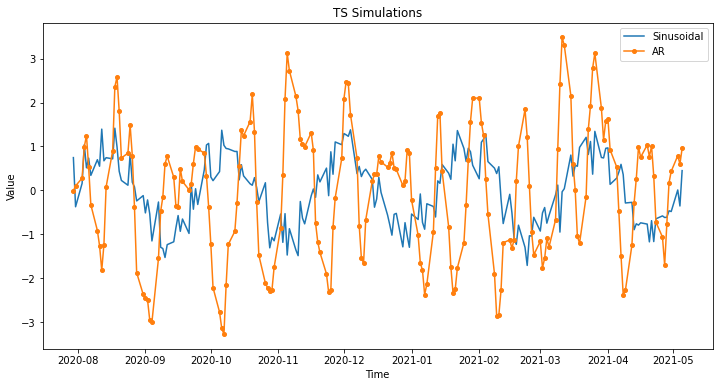

In [196]:
signal_w_errors = pd.DataFrame(signals+errors, index = XOM_returns[-200:].index)
samples = pd.DataFrame(samples[0], index = XOM_returns[-200:].index)
plt.figure(figsize = (12, 6))
plt.plot(signal_w_errors, label = 'Sinusoidal')
plt.plot(samples, marker='o', markersize=4, label = 'AR')
plt.xlabel('Time') #X-axis label
plt.ylabel('Value') #Y-axis label
plt.legend()
plt.title('TS Simulations');  #title of the plot 
plt.savefig('TS-Simulations.png')
plt.show()

# Training an LSTM (for use with the KF) to predict the Sinusoidal & AR Time Series

In [198]:
Outputs = 12
AR_lookback = 8
Sinusoidal_lookback = 50


X_sinusoidal_1, Y_sinusoidal_1 = helper_funcs.create_datasets(Sinusoidal_lookback, 1, signal_w_errors.values, 'Sinusoidal', signal_w_errors.values, False)
X_AR_1, Y_AR_1 = helper_funcs.create_datasets(AR_lookback, 1, samples.values, 'AR-2', samples.values, False)

X_sinusoidal, Y_sinusoidal = helper_funcs.create_datasets(Sinusoidal_lookback, Outputs, signal_w_errors.values, 'Sinusoidal', signal_w_errors.values, True)
X_AR, Y_AR = helper_funcs.create_datasets(AR_lookback, Outputs, samples.values, 'AR-2', samples.values, True)

X_sinusoidal_train_1, Y_sinusoidal_train_1, X_sinusoidal_val_1, Y_sinusoidal_val_1, X_sinusoidal_test_1, Y_sinusoidal_test_1  = helper_funcs.data_split(X_sinusoidal_1, Y_sinusoidal_1)
X_sinusoidal_train_1, Y_sinusoidal_train_1, X_sinusoidal_val_1, Y_sinusoidal_val_1, X_sinusoidal_test_1, Y_sinusoidal_test_1 = X_sinusoidal_train_1.to(device), Y_sinusoidal_train_1.to(device), X_sinusoidal_val_1.to(device), Y_sinusoidal_val_1.to(device), X_sinusoidal_test_1.to(device), Y_sinusoidal_test_1.to(device)

X_AR_train_1, Y_AR_train_1, X_AR_val_1, Y_AR_val_1, X_AR_test_1, Y_AR_test_1 = helper_funcs.data_split(X_AR_1, Y_AR_1)
X_AR_train_1, Y_AR_train_1, X_AR_val_1, Y_AR_val_1, X_AR_test_1, Y_AR_test_1 = X_AR_train_1.to(device), Y_AR_train_1.to(device), X_AR_val_1.to(device), Y_AR_val_1.to(device), X_AR_test_1.to(device), Y_AR_test_1.to(device)

X_sinusoidal_train, Y_sinusoidal_train, X_sinusoidal_val, Y_sinusoidal_val, X_sinusoidal_test, Y_sinusoidal_test  = helper_funcs.data_split(X_sinusoidal, Y_sinusoidal)
X_sinusoidal_train, Y_sinusoidal_train, X_sinusoidal_val, Y_sinusoidal_val, X_sinusoidal_test, Y_sinusoidal_test = X_sinusoidal_train.to(device), Y_sinusoidal_train.to(device), X_sinusoidal_val.to(device), Y_sinusoidal_val.to(device), X_sinusoidal_test.to(device), Y_sinusoidal_test.to(device)

X_AR_train, Y_AR_train, X_AR_val, Y_AR_val, X_AR_test, Y_AR_test = helper_funcs.data_split(X_AR, Y_AR)
X_AR_train, Y_AR_train, X_AR_val, Y_AR_val, X_AR_test, Y_AR_test = X_AR_train.to(device), Y_AR_train.to(device), X_AR_val.to(device), Y_AR_val.to(device), X_AR_test.to(device), Y_AR_test.to(device)


Shape of X: (150, 50, 1) Shape of Y: (150, 1)
Shape of X: (192, 8, 1) Shape of Y: (192, 1)
X shape : (137, 50, 1)
Y shape : (137, 12, 1)
Shape of X: (137, 50, 1) Shape of Y: (137, 12)
X shape : (179, 8, 1)
Y shape : (179, 12, 1)
Shape of X: (179, 8, 1) Shape of Y: (179, 12)


In [199]:
Outputs = 12
ts_hidden = 512
sinusoidal_model = LSTM(len(X_sinusoidal_train.T), ts_hidden, 1, Outputs)
sinusoidal_model.to(device)

sinusoidal_model_1 = LSTM(len(X_sinusoidal_train_1.T), ts_hidden, 1, 1)
sinusoidal_model_1.to(device)

AR_model = LSTM(len(X_AR_train.T), ts_hidden, 1, Outputs)
AR_model.to(device)

AR_model_1 = LSTM(len(X_AR_train_1.T), ts_hidden, 1, 1)
AR_model_1.to(device)

learning_rate = 1e-4
epochs = 2000
loss_function = nn.MSELoss()

AR_optimizer = torch.optim.Adam(AR_model.parameters(), lr = learning_rate)
sinusoidal_optimizer = torch.optim.Adam(sinusoidal_model.parameters(), lr = learning_rate)

AR_optimizer_1 = torch.optim.Adam(AR_model_1.parameters(), lr = learning_rate)
sinusoidal_optimizer_1 = torch.optim.Adam(sinusoidal_model_1.parameters(), lr = learning_rate)

AR_train_loss, AR_val_loss = full_gd(AR_model,
                                     loss_function,
                                     AR_optimizer,
                                     X_AR_train, 
                                     Y_AR_train, 
                                     X_AR_val,
                                     Y_AR_val, 
                                     epochs)

sinusoidal_train_loss, sinusoidal_val_loss = full_gd(sinusoidal_model,
                                                    loss_function, 
                                                    sinusoidal_optimizer,
                                                    X_sinusoidal_train, 
                                                    Y_sinusoidal_train, 
                                                    X_sinusoidal_val,
                                                    Y_sinusoidal_val, 
                                                    epochs)

AR_train_loss_1, AR_val_loss_1 = full_gd(AR_model_1,
                                     loss_function,
                                     AR_optimizer_1,
                                     X_AR_train_1, 
                                     Y_AR_train_1, 
                                     X_AR_val_1,
                                     Y_AR_val_1, 
                                     epochs)

sinusoidal_train_loss_1, sinusoidal_val_loss_1 = full_gd(sinusoidal_model_1,
                                                    loss_function, 
                                                    sinusoidal_optimizer_1,
                                                    X_sinusoidal_train_1, 
                                                    Y_sinusoidal_train_1, 
                                                    X_sinusoidal_val_1,
                                                    Y_sinusoidal_val_1, 
                                                    epochs)                                                    

Epoch 25/2000, Train Loss: 2.2544, Validation Loss: 2.3666
Epoch 50/2000, Train Loss: 2.0790, Validation Loss: 2.2646
Epoch 75/2000, Train Loss: 1.7454, Validation Loss: 2.0094
Epoch 100/2000, Train Loss: 1.5684, Validation Loss: 2.0739
Epoch 125/2000, Train Loss: 1.4952, Validation Loss: 2.1434
Epoch 150/2000, Train Loss: 1.4264, Validation Loss: 2.1156
Epoch 175/2000, Train Loss: 1.3391, Validation Loss: 2.0935
Epoch 200/2000, Train Loss: 1.2519, Validation Loss: 2.1017
Epoch 225/2000, Train Loss: 1.1671, Validation Loss: 2.0796
Epoch 250/2000, Train Loss: 1.0545, Validation Loss: 2.1251
Epoch 275/2000, Train Loss: 0.9375, Validation Loss: 2.1289
Epoch 300/2000, Train Loss: 0.8274, Validation Loss: 2.1580
Epoch 325/2000, Train Loss: 0.7319, Validation Loss: 2.1857
Epoch 350/2000, Train Loss: 0.6466, Validation Loss: 2.2132
Epoch 375/2000, Train Loss: 0.5754, Validation Loss: 2.2263
Epoch 400/2000, Train Loss: 0.5118, Validation Loss: 2.2892
Epoch 425/2000, Train Loss: 0.4533, Validat

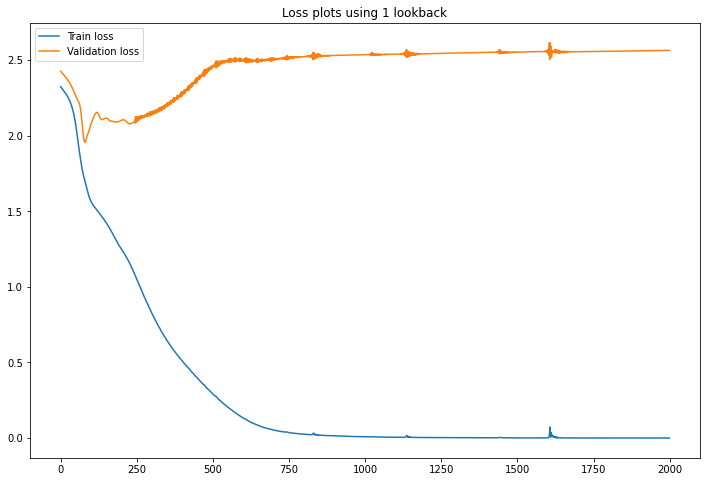

In [201]:
plot_loss_funcs(AR_train_loss, AR_val_loss, 1)

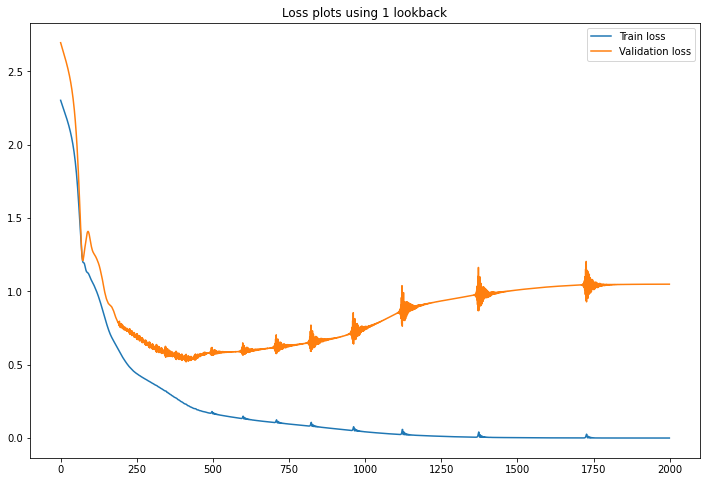

In [202]:
plot_loss_funcs(AR_train_loss_1, AR_val_loss_1, 1)

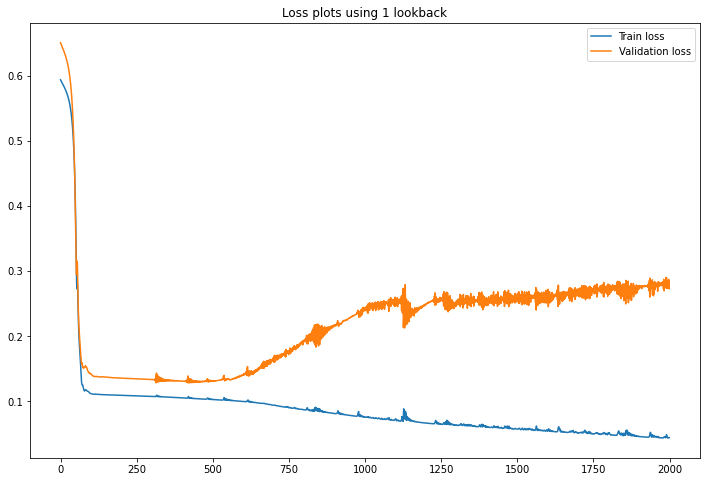

In [203]:
plot_loss_funcs(sinusoidal_train_loss, sinusoidal_val_loss, 1)

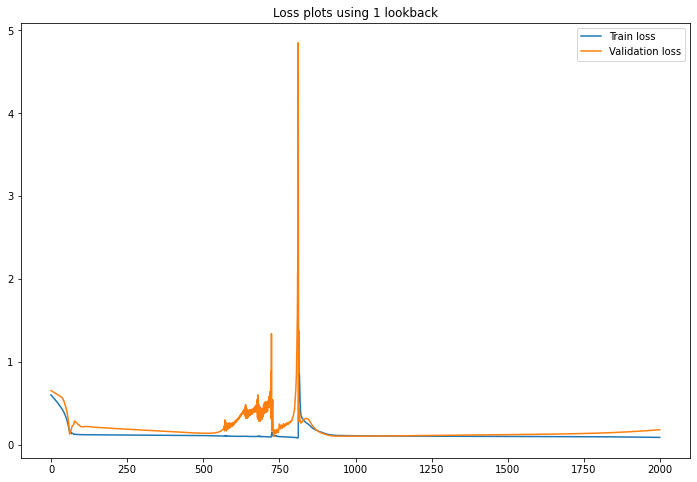

In [204]:
plot_loss_funcs(sinusoidal_train_loss_1, sinusoidal_val_loss_1, 1)

In [208]:
AR_preds = helper_funcs.make_predictions(AR_model, X_AR_test, Y_AR_test, 
                                                AR_lookback, len(X_AR_test.T),Outputs, True)

sinusoidal_preds = helper_funcs.make_predictions(sinusoidal_model, X_sinusoidal_test, Y_sinusoidal_test, 
                                                Sinusoidal_lookback, len(X_sinusoidal_test.T), Outputs, True)

signals = pd.DataFrame(signals, index = XOM_returns[-200:].index)
samples = pd.DataFrame(samples, index = XOM_returns[-200:].index)

Y_sinusoidal_train_df = pd.DataFrame(Y_sinusoidal_train, XOM_returns[-200:][:len(Y_sinusoidal_train)].index)
Y_AR_train_df = pd.DataFrame(Y_AR_train, XOM_returns[-200:][:len(X_AR_train)].index)

Y_sinusoidal_val_df = pd.DataFrame(Y_sinusoidal_val, XOM_returns[-200:][len(Y_sinusoidal_train) : len(Y_sinusoidal_train) + len(Y_sinusoidal_val)].index)
Y_AR_val_df = pd.DataFrame(Y_AR_val, XOM_returns[-200:][len(Y_AR_train) : len(Y_AR_train) + len(Y_AR_val)].index)

Y_sinusoidal_test_df = pd.DataFrame(Y_sinusoidal_test, XOM_returns[-200:][len(Y_sinusoidal_train) + len(Y_sinusoidal_val) : len(Y_sinusoidal_train) + len(Y_sinusoidal_val) + len(Y_sinusoidal_test)].index)
Y_AR_test_df = pd.DataFrame(Y_AR_test, XOM_returns[-200:][len(Y_AR_train) + len(Y_AR_val) : len(Y_AR_train) + len(Y_AR_val) + len(Y_AR_test)].index)


AR_preds_1 = helper_funcs.make_predictions(AR_model_1, X_AR_test_1, Y_AR_test_1, 
                                                AR_lookback, len(X_AR_test_1.T), 1, False)

sinusoidal_preds_1 = helper_funcs.make_predictions(sinusoidal_model_1, X_sinusoidal_test_1, Y_sinusoidal_test_1, 
                                                Sinusoidal_lookback, len(X_sinusoidal_test_1.T), 1, False)

AR_preds_1 = pd.DataFrame(AR_preds_1, index = XOM_returns[-200:][len(Y_AR_train_1) + len(Y_AR_val_1) : len(Y_AR_train_1) + len(Y_AR_val_1) + len(Y_AR_test_1)].index)
sinusoidal_preds_1 = pd.DataFrame(sinusoidal_preds_1, index = XOM_returns[-200:][len(Y_sinusoidal_train_1) + len(Y_sinusoidal_val_1) : len(Y_sinusoidal_train_1) + len(Y_sinusoidal_val_1) + len(Y_sinusoidal_test_1)].index)

signals_1 = pd.DataFrame(signals, index = XOM_returns[-200:].index)
samples_1 = pd.DataFrame(samples, index = XOM_returns[-200:].index)

Y_sinusoidal_train_1_df = pd.DataFrame(Y_sinusoidal_train_1, XOM_returns[-200:][:len(Y_sinusoidal_train_1)].index)
Y_AR_train_1_df = pd.DataFrame(Y_AR_train_1, XOM_returns[-200:][:len(X_AR_train_1)].index)

Y_sinusoidal_val_1_df = pd.DataFrame(Y_sinusoidal_val_1, XOM_returns[-200:][len(Y_sinusoidal_train_1) : len(Y_sinusoidal_train_1) + len(Y_sinusoidal_val_1)].index)
Y_AR_val_1_df = pd.DataFrame(Y_AR_val_1, XOM_returns[-200:][len(Y_AR_train_1) : len(Y_AR_train_1) + len(Y_AR_val_1)].index)

Y_sinusoidal_test_1_df = pd.DataFrame(Y_sinusoidal_test_1, XOM_returns[-200:][len(Y_sinusoidal_train_1) + len(Y_sinusoidal_val_1) : len(Y_sinusoidal_train_1) + len(Y_sinusoidal_val_1) + len(Y_sinusoidal_test_1)].index)
Y_AR_test_1_df = pd.DataFrame(Y_AR_test_1, XOM_returns[-200:][len(Y_AR_train_1) + len(Y_AR_val_1) : len(Y_AR_train_1) + len(Y_AR_val_1) + len(Y_AR_test_1)].index)

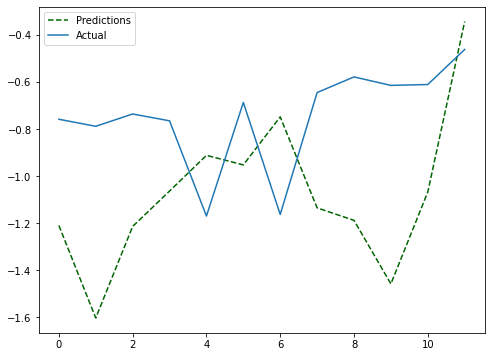

In [209]:
plt.figure(figsize=(8,6))
plt.plot(sinusoidal_preds[-3], label = 'Predictions', linestyle = 'dashed', color = 'darkgreen')
plt.plot(Y_sinusoidal_test[-3].detach().cpu(), label = 'Actual')
plt.legend()
plt.savefig('Sinusoidal-Multi-Step-Preds.png')
plt.show()

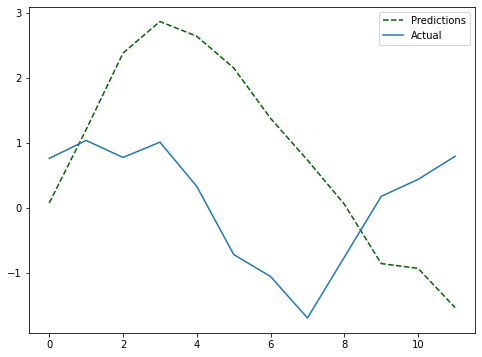

In [210]:
plt.figure(figsize=(8,6))
plt.plot(AR_preds[-1], label = 'Predictions', linestyle = 'dashed', color = 'darkgreen')
plt.plot(Y_AR_test[-1].detach().cpu(), label = 'Actual')
plt.legend()
plt.savefig('AR-Multi-Step-Preds.png')
plt.show()

In [211]:
print(type(Y_sinusoidal_test))
print(Y_sinusoidal_test.shape)

j = sinusoidal_model(X_sinusoidal_test)

print(j.shape)

<class 'torch.Tensor'>
torch.Size([28, 12])
torch.Size([28, 12])


In [212]:
print(len(signals))

print(len(Y_sinusoidal))

print(len(Y_sinusoidal_1))

200
137
150


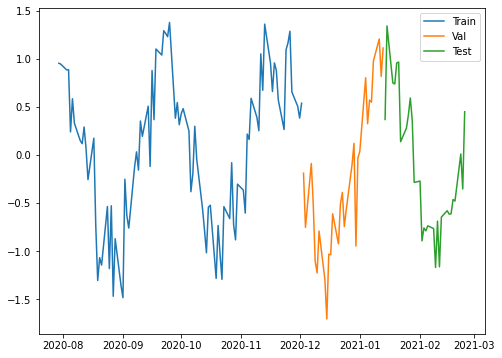

In [213]:
plt.figure(figsize = (8,6))
plt.plot(Y_sinusoidal_train_1_df, label = 'Train')
#plt.plot(np.cumsum(XOM_returns_m[:150]-1))
plt.plot(Y_sinusoidal_val_1_df, label = 'Val')
#plt.plot(np.cumsum(XOM_returns_m[150:200]-1))
plt.plot(Y_sinusoidal_test_1_df, label = 'Test')
#plt.plot(np.cumsum(XOM_returns_m[200:251]-1))
plt.legend()
plt.show()

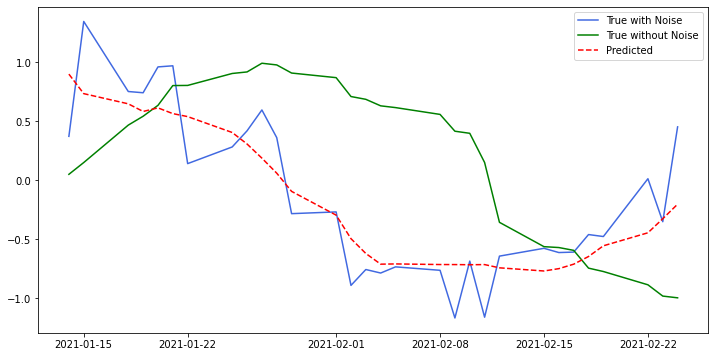

Mean Square Forecast Error: 0.09326773513040616


In [216]:
plt.figure(figsize=(12,6))
plt.plot(Y_sinusoidal_test_1_df, color = 'royalblue', label = 'True with Noise')
plt.plot(signals[len(Y_sinusoidal_train_1) + len(Y_sinusoidal_val_1) : len(Y_sinusoidal_train_1) + len(Y_sinusoidal_val_1) + len(Y_sinusoidal_test_1)], color = 'green', label = 'True without Noise')
plt.plot(sinusoidal_preds_1, color = 'red', linestyle = '--',label = 'Predicted')
plt.legend()
#plt.savefig('Sinusoidal-Predictions.png')
plt.show()


print(f'Mean Square Forecast Error: {mean_squared_error(Y_sinusoidal_test_1_df, sinusoidal_preds_1)}')

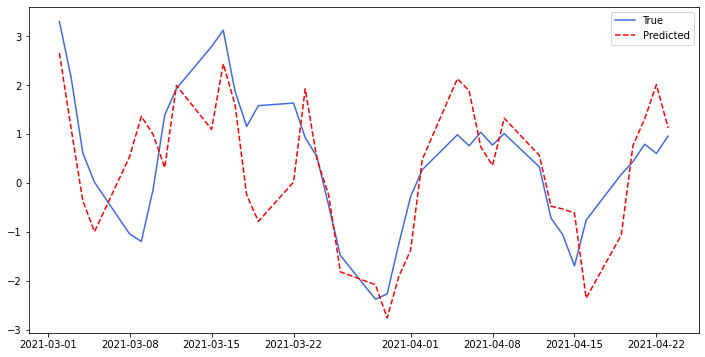

Mean Square Forecast Error: 1.0953541102716424


In [217]:
plt.figure(figsize=(12,6))
plt.plot(Y_AR_test_1_df, color = 'royalblue', label = 'True')
plt.plot(AR_preds_1, color = 'red', linestyle = '--',label = 'Predicted')
plt.legend()
plt.savefig('AR-Predictions.png')
plt.show()

print(f'Mean Square Forecast Error: {mean_squared_error(Y_AR_test_1_df, AR_preds_1)}')

Length of validation data: 38
89


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


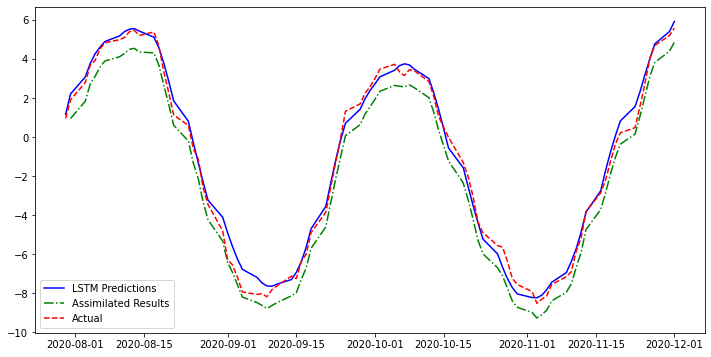

Mean Square Forecast Error: 0.08798691555322787
Mean Square Forecast Error: 0.02581681367249361


In [220]:
# One-step predictions 

import collections

print(f'Length of validation data: {len(Y_AR_val_1_df)}')

LSTM_Sinusoidal_train_assimilated_results_1 = collections.deque()

Sin_train_pred_var = collections.deque()
Sin_train_obs = collections.deque()

for i in range(len(X_sinusoidal_train_1)-1):

    input = torch.unsqueeze(X_sinusoidal_train_1[i], 0)
    
    sin_train_pred = sinusoidal_model_1(input)
    sin_train_pred = sin_train_pred.cpu().detach().numpy().item()
    Sin_train_pred_var.append(sin_train_pred)

    observation = Y_sinusoidal_train_1_df[0][i].cpu().detach().numpy().item()
    Sin_train_obs.append(observation)

    Kalman_gain = np.var(Sin_train_pred_var) * 1/(np.var(Sin_train_pred_var) + np.var(Sin_train_obs)) 
    
    analysis_obs = sin_train_pred + Kalman_gain * (observation - sin_train_pred) 

    LSTM_Sinusoidal_train_assimilated_results_1.append(np.array(analysis_obs))

print(len(LSTM_Sinusoidal_train_assimilated_results_1))
LSTM_Sinusoidal_train_assimilated_results_1 = pd.DataFrame(LSTM_Sinusoidal_train_assimilated_results_1, index = Y_sinusoidal_train_1_df[:-1].index)
LSTM_Sinusoidal_train_assimilated_results_1.dropna(inplace=True)

Sin_train_pred_var = pd.DataFrame(np.array(Sin_train_pred_var), index = Y_sinusoidal_train_1_df[:-1].index)
Sin_train_obs = pd.DataFrame(np.array(Sin_train_obs), index = Y_sinusoidal_train_1_df[:-1].index)

# Monthly
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(Sin_train_pred_var), label='LSTM Predictions', color = 'blue')
plt.plot(np.cumsum(LSTM_Sinusoidal_train_assimilated_results_1), label='Assimilated Results',  color = 'green', linestyle = '-.')
plt.plot(np.cumsum(Sin_train_obs), label='Actual',  color = 'red', linestyle = '--')
plt.legend()
plt.savefig('KF-Sin-Train.png')
plt.show()

print(f'Mean Square Forecast Error: {mean_squared_error(Sin_train_obs, Sin_train_pred_var)}')
print(f'Mean Square Forecast Error: {mean_squared_error(Sin_train_obs[1:], LSTM_Sinusoidal_train_assimilated_results_1)}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


29


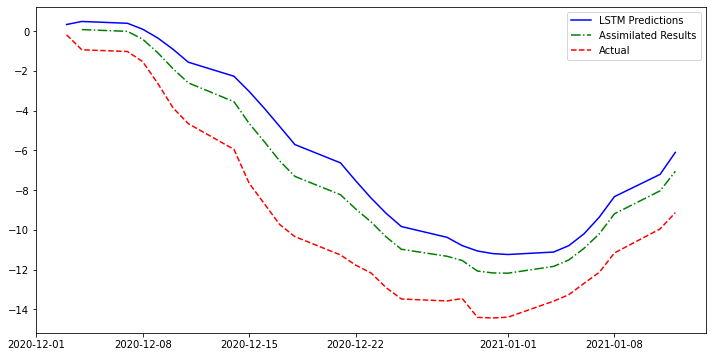

Mean Square Forecast Error: 0.1855152025078659
Mean Square Forecast Error: 0.08361741100928954


In [231]:

LSTM_Sinusoidal_val_assimilated_results_1 = collections.deque()

Sin_val_pred_var_1 = collections.deque()
Sin_val_obs_1 = collections.deque()

for i in range(len(X_sinusoidal_val_1)-1):

    input = torch.unsqueeze(X_sinusoidal_val_1[i], 0)
    
    sin_val_pred = sinusoidal_model_1(input)
    sin_val_pred = sin_val_pred.cpu().detach().numpy().item()
    Sin_val_pred_var_1.append(sin_val_pred)

    observation = Y_sinusoidal_val_1_df[0][i].cpu().detach().numpy().item()
    Sin_val_obs_1.append(observation)

    Kalman_gain = np.var(Sin_val_pred_var_1) * 1/(np.var(Sin_val_pred_var_1) + np.var(Sin_val_obs_1)) 
    
    analysis_obs = sin_val_pred + Kalman_gain * (observation - sin_val_pred) 

    LSTM_Sinusoidal_val_assimilated_results_1.append(np.array(analysis_obs))

print(len(LSTM_Sinusoidal_val_assimilated_results_1))
LSTM_Sinusoidal_val_assimilated_results_1 = pd.DataFrame(LSTM_Sinusoidal_val_assimilated_results_1, index = Y_sinusoidal_val_1_df[:-1].index)
LSTM_Sinusoidal_val_assimilated_results_1.dropna(inplace=True)

Sin_val_pred_var_1 = pd.DataFrame(np.array(Sin_val_pred_var_1), index = Y_sinusoidal_val_1_df[:-1].index)
Sin_val_obs_1 = pd.DataFrame(np.array(Sin_val_obs_1), index = Y_sinusoidal_val_1_df[:-1].index)

# Monthly
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(Sin_val_pred_var_1), label='LSTM Predictions', color = 'blue')
plt.plot(np.cumsum(LSTM_Sinusoidal_val_assimilated_results_1), label='Assimilated Results',  color = 'green', linestyle = '-.')
plt.plot(np.cumsum(Sin_val_obs_1), label='Actual',  color = 'red', linestyle = '--')
plt.legend()
plt.savefig('KF-Sin-Val.png')
plt.show()

print(f'Mean Square Forecast Error: {mean_squared_error(Sin_val_obs_1, Sin_val_pred_var_1)}')
print(f'Mean Square Forecast Error: {mean_squared_error(Sin_val_obs_1[1:], LSTM_Sinusoidal_val_assimilated_results_1)}')

Length of validation data: 39
29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


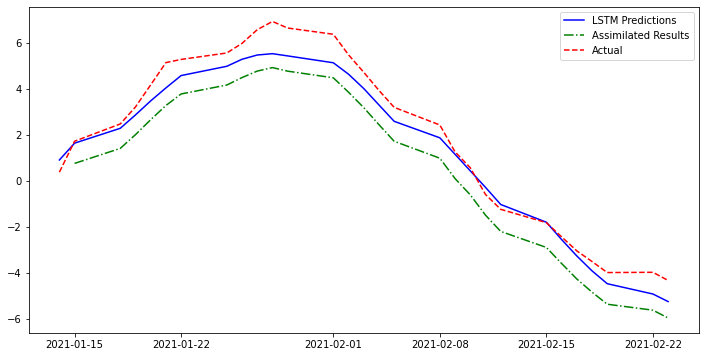

Mean Square Forecast Error: 0.08168126768190354
Mean Square Forecast Error: 0.04526735542504218


In [230]:
print(f'Length of validation data: {len(Y_AR_test_1_df)}')

LSTM_Sinusoidal_test_assimilated_results_1 = collections.deque()

Sin_test_pred_var_1 = collections.deque()
Sin_test_obs_1 = collections.deque()

for i in range(len(X_sinusoidal_test_1)-1):

    input = torch.unsqueeze(X_sinusoidal_test_1[i], 0)
    
    sin_test_pred = sinusoidal_model_1(input)
    sin_test_pred = sin_test_pred.cpu().detach().numpy().item()
    Sin_test_pred_var_1.append(sin_test_pred)

    observation = Y_sinusoidal_test_1_df[0][i].cpu().detach().numpy().item()
    Sin_test_obs_1.append(observation)

    Kalman_gain = np.var(Sin_test_pred_var_1) * 1/(np.var(Sin_test_pred_var_1) + np.var(Sin_test_obs_1)) 
    
    analysis_obs = sin_test_pred + Kalman_gain * (observation - sin_test_pred) 

    LSTM_Sinusoidal_test_assimilated_results_1.append(np.array(analysis_obs))

print(len(LSTM_Sinusoidal_test_assimilated_results_1))
LSTM_Sinusoidal_test_assimilated_results_1 = pd.DataFrame(LSTM_Sinusoidal_test_assimilated_results_1, index = Y_sinusoidal_test_1_df[:-1].index)
LSTM_Sinusoidal_test_assimilated_results_1.dropna(inplace=True)

Sin_test_pred_var = pd.DataFrame(np.array(Sin_test_pred_var_1), index = Y_sinusoidal_test_1_df[:-1].index)
Sin_test_obs = pd.DataFrame(np.array(Sin_test_obs_1), index = Y_sinusoidal_test_1_df[:-1].index)

# Monthly
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(Sin_test_pred_var), label='LSTM Predictions', color = 'blue')
plt.plot(np.cumsum(LSTM_Sinusoidal_test_assimilated_results_1), label='Assimilated Results',  color = 'green', linestyle = '-.')
plt.plot(np.cumsum(Sin_test_obs), label='Actual',  color = 'red', linestyle = '--')
plt.legend()
plt.savefig('KF-Sin-Test.png')
plt.show()

print(f'Mean Square Forecast Error: {mean_squared_error(Sin_test_obs, Sin_test_pred_var)}')
print(f'Mean Square Forecast Error: {mean_squared_error(Sin_test_obs[1:], LSTM_Sinusoidal_test_assimilated_results_1)}')

Length of validation data: 90
89


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


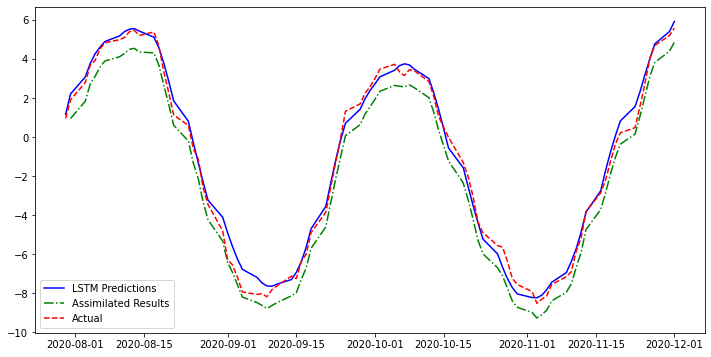

Mean Square Forecast Error: 0.08798691555322787
Mean Square Forecast Error: 0.02581681367249361


In [229]:


print(f'Length of validation data: {len(Y_sinusoidal_train_1_df)}')

LSTM_Sinusoidal_train_assimilated_results_1 = collections.deque()

Sin_train_pred_var_1 = collections.deque()
Sin_train_obs_1 = collections.deque()

for i in range(len(X_sinusoidal_train_1)-1):

    input = torch.unsqueeze(X_sinusoidal_train_1[i], 0)
    
    sin_train_pred = sinusoidal_model_1(input)
    sin_train_pred = sin_train_pred.cpu().detach().numpy().item()
    Sin_train_pred_var_1.append(sin_train_pred)

    observation = Y_sinusoidal_train_1_df[0][i].cpu().detach().numpy().item()
    Sin_train_obs_1.append(observation)

    Kalman_gain = np.var(Sin_train_pred_var_1) * 1/(np.var(Sin_train_pred_var_1) + np.var(Sin_train_obs_1)) 
    
    analysis_obs = sin_train_pred + Kalman_gain * (observation - sin_train_pred) 

    LSTM_Sinusoidal_train_assimilated_results_1.append(np.array(analysis_obs))

print(len(LSTM_Sinusoidal_train_assimilated_results_1))
LSTM_Sinusoidal_train_assimilated_results_1 = pd.DataFrame(LSTM_Sinusoidal_train_assimilated_results_1, index = Y_sinusoidal_train_1_df[:-1].index)
LSTM_Sinusoidal_train_assimilated_results_1.dropna(inplace=True)

Sin_train_pred_var_1 = pd.DataFrame(np.array(Sin_train_pred_var_1), index = Y_sinusoidal_train_1_df[:-1].index)
Sin_train_obs_1 = pd.DataFrame(np.array(Sin_train_obs_1), index = Y_sinusoidal_train_1_df[:-1].index)

# Monthly
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(Sin_train_pred_var_1), label='LSTM Predictions', color = 'blue')
plt.plot(np.cumsum(LSTM_Sinusoidal_train_assimilated_results_1), label='Assimilated Results',  color = 'green', linestyle = '-.')
plt.plot(np.cumsum(Sin_train_obs_1), label='Actual',  color = 'red', linestyle = '--')
plt.legend()
plt.savefig('KF-Sin-Train.png')
plt.show()

print(f'Mean Square Forecast Error: {mean_squared_error(Sin_train_obs_1, Sin_train_pred_var_1)}')
print(f'Mean Square Forecast Error: {mean_squared_error(Sin_train_obs_1[1:], LSTM_Sinusoidal_train_assimilated_results_1)}')

Length of validation data: 115
114


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


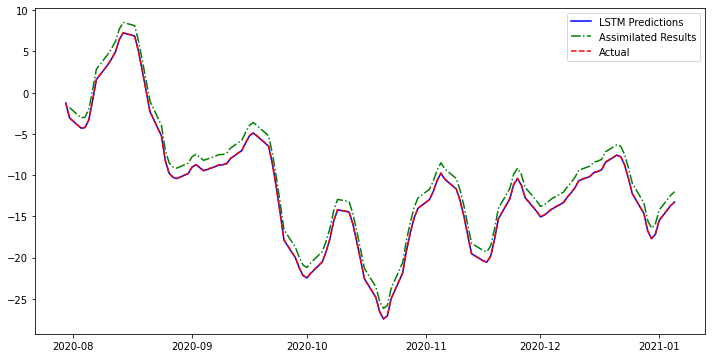

Mean Square Forecast Error: 0.0001012396527879017
Mean Square Forecast Error: 2.5416394057236486e-05


In [228]:


print(f'Length of validation data: {len(Y_AR_train_1_df)}')

LSTM_AR_train_assimilated_results_1 = collections.deque()

AR_train_pred_var_1 = collections.deque()
AR_obs_train_1 = collections.deque()

for i in range(len(X_AR_train_1)-1):

    input = torch.unsqueeze(X_AR_train_1[i], 0)
    
    train_pred = AR_model_1(input)
    train_pred = train_pred.cpu().detach().numpy().item()
    AR_train_pred_var_1.append(train_pred)

    observation = Y_AR_train_1_df[0][i].cpu().detach().numpy().item()
    AR_obs_train_1.append(observation)

    Kalman_gain = np.var(AR_train_pred_var_1) * 1/(np.var(AR_train_pred_var_1) + np.var(AR_obs_train_1)) 
    
    analysis_obs = train_pred + Kalman_gain * (observation - train_pred) 

    LSTM_AR_train_assimilated_results_1.append(np.array(analysis_obs))

print(len(LSTM_AR_train_assimilated_results_1))
AR_train_assimilated_results_1 = pd.DataFrame(LSTM_AR_train_assimilated_results_1, index = Y_AR_train_1_df[:-1].index)
AR_train_assimilated_results_1.dropna(inplace=True)

AR_train_pred_df_1 = pd.DataFrame(np.array(AR_train_pred_var_1), index = Y_AR_train_1_df[:-1].index)
AR_train_obs_df_1 = pd.DataFrame(np.array(AR_obs_train_1), index = Y_AR_train_1_df[:-1].index)

# Monthly
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(AR_train_pred_df_1), label='LSTM Predictions', color = 'blue')
plt.plot(np.cumsum(AR_train_assimilated_results_1), label='Assimilated Results',  color = 'green', linestyle = '-.')
plt.plot(np.cumsum(AR_train_obs_df_1), label='Actual',  color = 'red', linestyle = '--')
plt.legend()
plt.savefig('KF-AR-train.png')
plt.show()

print(f'Mean Square Forecast Error: {mean_squared_error(AR_train_obs_df_1, AR_train_pred_df_1)}')
print(f'Mean Square Forecast Error: {mean_squared_error(AR_train_obs_df_1[1:], AR_train_assimilated_results_1)}')

Length of validation data: 38
37


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


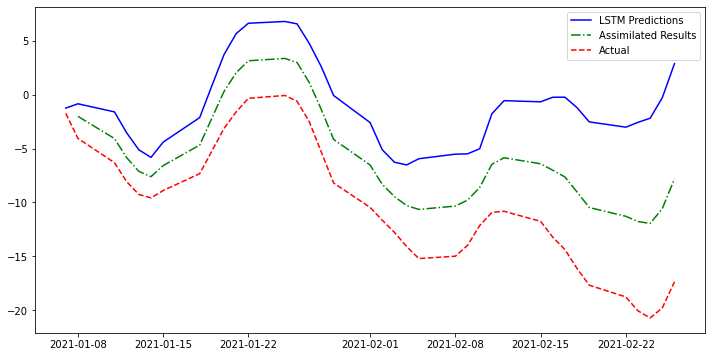

Mean Square Forecast Error: 1.0751994501729238
Mean Square Forecast Error: 0.17942088323440053


In [227]:


print(f'Length of validation data: {len(Y_AR_val_1_df)}')

LSTM_AR_val_assimilated_results_1 = collections.deque()

AR_pred_var_1 = collections.deque()
AR_obs_val_1 = collections.deque()

for i in range(len(X_AR_val_1)-1):

    input = torch.unsqueeze(X_AR_val_1[i], 0)
    
    val_pred = AR_model_1(input)
    val_pred = val_pred.cpu().detach().numpy().item()
    AR_pred_var_1.append(val_pred)

    observation = Y_AR_val_1_df[0][i].cpu().detach().numpy().item()
    AR_obs_val_1.append(observation)

    Kalman_gain = np.var(AR_pred_var_1) * 1/(np.var(AR_pred_var_1) + np.var(AR_obs_val_1)) 
    
    analysis_obs = val_pred + Kalman_gain * (observation - val_pred) 

    LSTM_AR_val_assimilated_results_1.append(np.array(analysis_obs))

print(len(LSTM_AR_val_assimilated_results_1))
AR_val_assimilated_results_1 = pd.DataFrame(LSTM_AR_val_assimilated_results_1, index = Y_AR_val_1_df[:-1].index)
AR_val_assimilated_results_1.dropna(inplace=True)

AR_val_pred_df_1 = pd.DataFrame(np.array(AR_pred_var_1), index = Y_AR_val_1_df[:-1].index)
AR_val_obs_df_1 = pd.DataFrame(np.array(AR_obs_val_1), index = Y_AR_val_1_df[:-1].index)

# Monthly
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(AR_val_pred_df_1), label='LSTM Predictions', color = 'blue')
plt.plot(np.cumsum(AR_val_assimilated_results_1), label='Assimilated Results',  color = 'green', linestyle = '-.')
plt.plot(np.cumsum(AR_val_obs_df_1), label='Actual',  color = 'red', linestyle = '--')
plt.legend()
plt.savefig('KF-AR-Val.png')
plt.show()

print(f'Mean Square Forecast Error: {mean_squared_error(AR_val_obs_df_1, AR_val_pred_df_1)}')
print(f'Mean Square Forecast Error: {mean_squared_error(AR_val_obs_df_1[1:], AR_val_assimilated_results_1)}')

Length of validation data: 39
38


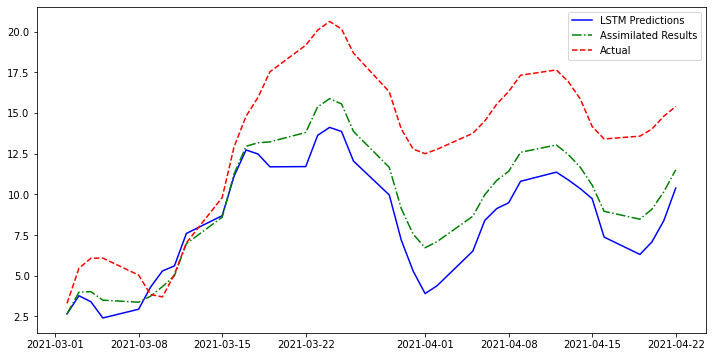

Mean Square Forecast Error: 1.123430016886358
Mean Square Forecast Error: 0.42126283724407765


In [232]:


print(f'Length of validation data: {len(Y_AR_test_1_df)}')

LSTM_AR_test_assimilated_results_1 = collections.deque()

AR_pred_var_1 = collections.deque()
AR_obs_test_1 = collections.deque()

for i in range(len(X_AR_test_1)-1):

    input = torch.unsqueeze(X_AR_test_1[i], 0)
    
    test_pred = AR_model_1(input)
    test_pred = test_pred.cpu().detach().numpy().item()
    AR_pred_var_1.append(test_pred)

    observation = Y_AR_test_1_df[0][i].cpu().detach().numpy().item()
    AR_obs_test_1.append(observation)

    Kalman_gain = np.var(AR_pred_var_1) * 1/(np.var(AR_pred_var_1) + np.var(AR_obs_val_1)) 
    
    analysis_obs = test_pred + Kalman_gain * (observation - test_pred) 

    LSTM_AR_test_assimilated_results_1.append(np.array(analysis_obs))

print(len(LSTM_AR_test_assimilated_results_1))
AR_test_assimilated_results_1 = pd.DataFrame(LSTM_AR_test_assimilated_results_1, index = Y_AR_test_1_df[:-1].index)

AR_test_pred_df_1 = pd.DataFrame(np.array(AR_pred_var_1), index = Y_AR_test_1_df[:-1].index)
AR_test_obs_df_1 = pd.DataFrame(np.array(AR_obs_test_1), index = Y_AR_test_1_df[:-1].index)

# Monthly
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(AR_test_pred_df_1), label='LSTM Predictions', color = 'blue')
plt.plot(np.cumsum(AR_test_assimilated_results_1), label='Assimilated Results',  color = 'green', linestyle = '-.')
plt.plot(np.cumsum(AR_test_obs_df_1), label='Actual',  color = 'red', linestyle = '--')
plt.legend()
plt.savefig('KF-AR-Test.png')
plt.show()

print(f'Mean Square Forecast Error: {mean_squared_error(AR_test_obs_df_1, AR_test_pred_df_1)}')
print(f'Mean Square Forecast Error: {mean_squared_error(AR_test_obs_df_1, AR_test_assimilated_results_1)}')